# Code for Producing Figure 1  

### From the paper:  
**"The Cultural Macroevolution of Arcade Video Games: Innovation, Collaboration, and Collapse"**  

**Authors:**  
Sergi Valverde, Blai Vidiella, Andrej Spiridonov, R. Alexander Bentley  

**Date:** April 24, 2025  
**Location:** Barcelona  

This notebook generates **Figure 1**, visualizing the hierarchical structure and temporal evolution of arcade video game genres.

**Data Source**  
- The script loads data from `arcade.csv`, a dataset containing arcade game information.  
- Each row represents an arcade game with attributes such as:  
  - `main_category` (e.g., Shooter, Fighter, Maze)  
  - `sub_category` (e.g., Aerial Combat, Gun-Based)  
  - `log_rom_size` (log-transformed ROM storage size)  
  - `log_clock_speed` (log-transformed CPU clock speed)  
  - `collaboration` (e.g., bootleg vs. collaboration)  

The ete3 library may have compatibility issues with some Python installations. Specifically:

If you're using conda, install ete3 via conda instead of pip:

> conda install -c etetoolkit ete3

If you're using an Apple Silicon-based Mac (like M1/M2), certain Python packages might not work well out of the box. Ensure you are using a compatible Python environment (e.g., via miniforge).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from ete3 import Tree, TreeStyle
from scipy.optimize import curve_fit
from scipy.stats import weibull_min
from IPython.display import SVG, display

/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/coretype/tree.py:365: SyntaxWarning: invalid escape sequence '\-'
/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/coretype/tree.py:436: SyntaxWarning: invalid escape sequence '\-'
/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/coretype/tree.py:1508: SyntaxWarning: invalid escape sequence '\-'
/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/coretype/tree.py:365: SyntaxWarning: invalid escape sequence '\-'
/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/coretype/tree.py:436: SyntaxWarning: invalid escape sequence '\-'
/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/coretype/tree.py:1508: SyntaxWarning: invalid escape sequence '\-'
/Users/sergi/miniconda3/lib/python3.12/site-packages/ete3-3.1.3-py3.10.egg/ete3/parser/newick.py:51: SyntaxWarning: invali

In [2]:
# Load dataset
df_prod = pd.read_csv('arcade.csv', dtype={"main_category": "string", "sub_category": "string", "title": "string"})
print(df_prod.info())

# Create dictionary mapping from category_id to (main_category, sub_category)
category_map = (
    df_prod
    .drop_duplicates(subset="category_id")[["category_id", "main_category", "sub_category"]]
    .set_index("category_id")
    .apply(tuple, axis=1)
    .to_dict()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7822 non-null   int64  
 1   year             7822 non-null   float64
 2   title            7822 non-null   string 
 3   firm             7822 non-null   object 
 4   firm_id          7822 non-null   int64  
 5   log_rom_size     7822 non-null   float64
 6   log_clock_speed  7822 non-null   float64
 7   collaboration    7822 non-null   object 
 8   main_category    7822 non-null   string 
 9   sub_category     7822 non-null   string 
 10  category_id      7822 non-null   int64  
dtypes: float64(3), int64(3), object(2), string(3)
memory usage: 672.3+ KB
None


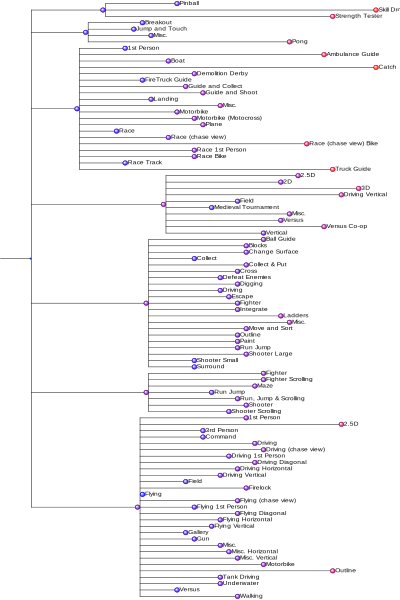

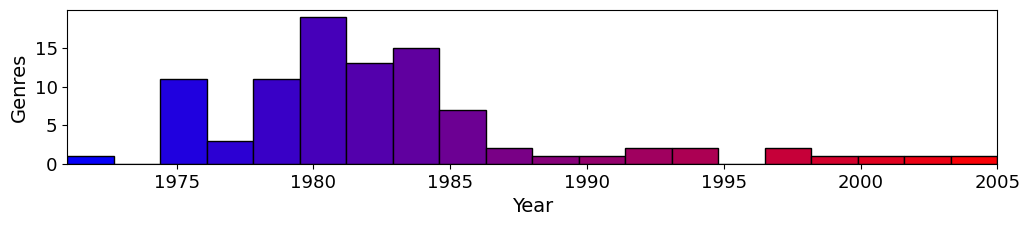

In [3]:



# Function to build the hierarchical tree
def build_tree(df):
    root = Tree(name="Machines")
    main_nodes = {}

    for (main_category, sub_category), group in df.groupby(['main_category', 'sub_category']):
        min_year = group['year'].min()
        
        # Add main category node if not exists
        if main_category not in main_nodes:
            main_nodes[main_category] = root.add_child(name=main_category)
            main_nodes[main_category].add_features(year=min_year)   

        # Add subcategory node under the main category
        sub_node = main_nodes[main_category].add_child(name=sub_category)
        sub_node.add_features (year=min_year) 
    return root

tree = build_tree(df_prod)

# Normalize year values for spacing
years = [node.year for node in tree.traverse() if "year" in node.features]
min_year, max_year = min(years), max(years)
scaling_factor = 10 / max(1, max_year - min_year)  # Avoid division by zero

# Define color gradient
cmap = mcolors.LinearSegmentedColormap.from_list("year_gradient", ["blue", "red"])

# Assign colors and distances to nodes
for node in tree.traverse():
    if "year" in node.features:
        normalized_year = (node.year - min_year) / max(1, max_year - min_year)
        node.dist = (node.year - min_year) * scaling_factor
        node.add_features(color=mcolors.to_hex(cmap(normalized_year)))

# Configure tree style
ts = TreeStyle()
ts.mode = "r"
ts.show_leaf_name = True
ts.show_scale = ts.show_branch_length = ts.show_branch_support = False
ts.orientation = 0
ts.branch_vertical_margin = 2
ts.scale = 60

# Apply node colors
for node in tree.traverse():
    if "color" in node.features:
        node.img_style["fgcolor"] = node.color
        node.img_style["size"] = 10
        node.img_style["shape"] = "sphere"

# Export tree visualization
tree.render("tree.svg", tree_style=ts, w=400, h=600)

# Load the SVG from the file
with open("tree.svg", "r", encoding="utf-8") as f:
    tree_svg_str = f.read()

# Display it inside Jupyter
display(SVG(tree_svg_str))

# Generate genre summary
def generate_genre_summary(tree, df):
    summary = []

    for main_node in tree.children:
        for sub_node in main_node.children:
            genre_data = df[(df["main_category"] == main_node.name) & (df["sub_category"] == sub_node.name)]
            if not genre_data.empty:
                summary.append({
                    "category_id": genre_data["category_id"].iloc[0],
                    "year": genre_data["year"].min(),
                    "last_year": genre_data["year"].max(),
                    "title": genre_data.loc[genre_data["year"].idxmin(), "title"],
                    "main_category": main_node.name,
                    "sub_category": sub_node.name,
                    "min(log_rom_size)": genre_data["log_rom_size"].min(),
                    "max(log_rom_size)": genre_data["log_rom_size"].max(),
                    "min(log_clock_speed)": genre_data["log_clock_speed"].min(),
                    "max(log_clock_speed)": genre_data["log_clock_speed"].max(),
                    "games": len(genre_data)
                })
    return pd.DataFrame(summary)

df_summary = generate_genre_summary(tree, df_prod)

# Panel B: Histogram of genres per year
# ----------------------------
plt.figure(figsize=(12, 2))

# Set up color map
years = df_summary["year"].astype(float)
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())
bins = np.linspace(years.min(), years.max(), 21)
hist, bin_edges = np.histogram(years, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_colors = [cmap(norm(center)) for center in bin_centers]
bars = plt.bar(bin_centers, hist, width=np.diff(bin_edges), align="center", edgecolor="black")
for bar, color in zip(bars, bin_colors):
    bar.set_facecolor(color)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Genres", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(years.min(), years.max())
plt.show()




/var/folders/3l/70ztmyn118z3pjq5dv4x6kvc0000gr/T/ipykernel_2310/2097511705.py:79: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2000)


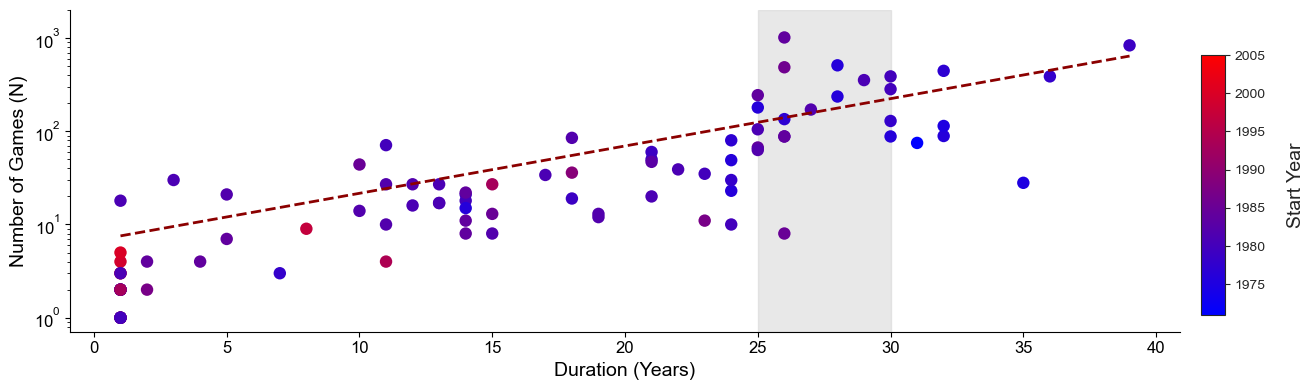

In [4]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from adjustText import adjust_text


# Panel C: Histogram of games per year (with genre labels)
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4))

# Perform exponential curve fitting
x = df_summary['last_year'] - df_summary['year'] + 1
y = df_summary['games']
c = df_summary['year']

# Exponential fit
def exp_func(x, a, b):
    return a * np.exp(b * x)
popt, _ = curve_fit(exp_func, x, y, p0=(1, 1))
a_opt, b_opt = popt
x_fit = np.linspace(x.min(), x.max(), len(x))
y_fit = exp_func(x_fit, *popt)

# Plot
sns.set_style("white")

# Highlight the duration range 25–30 with a gray rectangle
ax.axvspan(25, 30, color='lightgray', alpha=0.5, zorder=0)

sc = ax.scatter(x, y, c=c, cmap=cmap, s=80, alpha=1, edgecolors='none', zorder=2)
ax.plot(x_fit, y_fit, label=f"$N(d) = {a_opt:.1f} e^{{{b_opt:.2f} d}}$", color="darkred", linewidth=2, zorder=3, linestyle="dashed")

if 0:
    # Annotate points
    for _, row in df_summary.iterrows():
        main_category = row['main_category']
        sub_category = row['sub_category']
        cat = row['category_id']
        if cat in [26,   # category for Gradius
                   # The following list is computed by load_collapsing(df_prod, "Shooter") (see fig3.ipynb)
                   # 8, 15, 35, 86 # categories for collapsing shooter subgenres
                   15,   # category for Shooter / Command ( Missile Command)
                   68,   # category for Fighter / Versus ( Mortal Kombat)
                   37,   # category for Driving / Race (chase view) ( Outrun)
                   70,   # category for Platform/Fighter Scrolling (Rastan Saga)
                   10,   # category for Maze / Collect (Pac-man)
                   ]:
            print (cat, ":", category_map[cat])
            label = f"{row['main_category']} / {row['sub_category']}"
            ax.text(row['last_year'] - row['year'] + 1, row['games'], label, fontsize=8,
                ha='left', va='center', alpha=0.8)
if 0:
    # Separate label groups
    texts_adjust = []
    for _, row in df_summary.iterrows():
        label = f"{row['main_category']} / {row['sub_category']}"
        dx = np.random.uniform(-1.5, 1.5)
        dy = np.random.uniform(-0.1, 0.1) * row["games"]
        duration = row['last_year'] - row['year'] + 1

        if 0 <= duration <= 5:
            # This label will be adjusted
            text = ax.text(duration + dx, row['games'] + dy, label,
                        fontsize=8, alpha=0.8)
            texts_adjust.append(text)
        else:
            # This label stays where it is
            ax.text(duration + dx, row['games'] + dy, label,
                    fontsize=8, alpha=0.8)

    # Adjust only the cluttered short-duration labels
    adjust_text(texts_adjust, ax=ax,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
# Axis and style
ax.set_xlabel("Duration (Years)", fontsize=14)
ax.set_ylabel("Number of Games (N)", fontsize=14)
ax.set_yscale("log")
ax.set_ylim(0, 2000)
ax.tick_params(labelsize=12)
# ax.legend(fontsize=11)
sns.despine()
fig.tight_layout()

# Add colorbar on the right
cax = fig.add_axes([1.005, 0.2, 0.02, 0.65])  # [left, bottom, width, height]
norm = Normalize(vmin=c.min(), vmax=c.max())
cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_label('Start Year', fontsize=14, labelpad=15)
cb.ax.tick_params(labelsize=10)
# plt.savefig("fig1c.svg", bbox_inches='tight', dpi=300)
plt.show()


In [5]:
df_prod[ df_prod [ 'category_id'] == 15 ]


,Unnamed: 0,year,title,firm,firm_id,log_rom_size,log_clock_speed,collaboration,main_category,sub_category,category_id
89,89,1978.0,Sky Raider,Atari,4,4.080338,0.003461,single,Shooter,Command,15
501,501,1980.0,Missile Command (rev 2),Atari,4,4.090611,0.096910,single,Shooter,Command,15
505,505,1980.0,Missile Command (rev 1),Atari,4,4.090611,0.096910,single,Shooter,Command,15
506,506,1980.0,Missile Command (rev 3),Atari,4,4.090611,0.096910,single,Shooter,Command,15
611,611,1980.0,Missile Combat (Sidam bootleg),Sidam,14,4.090611,0.096910,bootleg,Shooter,Command,15
612,612,1980.0,"Missile Combat (Videotron bootleg, set 2)",Videotron,78,4.090611,0.096910,bootleg,Shooter,Command,15
615,615,1980.0,"Missile Combat (Videotron bootleg, set 1)",Videotron,78,4.090611,0.096910,bootleg,Shooter,Command,15
702,702,1981.0,Super Missile Attack (for rev 1),Atari,4,4.228606,0.096910,collaboration,Shooter,Command,15
703,703,1981.0,Super Missile Attack (for rev 1),General Computer Corporation,170,4.228606,0.096910,collaboration,Shooter,Command,15
706,706,1981.0,Super Missile Attack (not encrypted),Atari,4,4.090611,0.096910,collaboration,Shooter,Command,15


/var/folders/3l/70ztmyn118z3pjq5dv4x6kvc0000gr/T/ipykernel_2310/2684006022.py:79: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(-100, 1100)


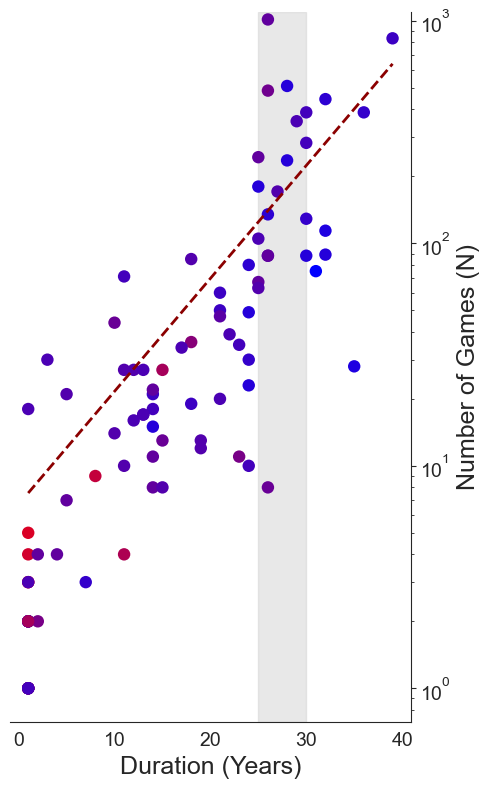

In [6]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from adjustText import adjust_text


# Panel C: Histogram of games per year (with genre labels)
# ----------------------------
fig, ax = plt.subplots(figsize=(5, 8))

# Perform exponential curve fitting
x = df_summary['last_year'] - df_summary['year'] + 1
y = df_summary['games']
c = df_summary['year']

# Exponential fit
def exp_func(x, a, b):
    return a * np.exp(b * x)
popt, _ = curve_fit(exp_func, x, y, p0=(1, 1))
a_opt, b_opt = popt
x_fit = np.linspace(x.min(), x.max(), len(x))
y_fit = exp_func(x_fit, *popt)

# Plot
sns.set_style("white")

# Highlight the duration range 25–30 with a gray rectangle
ax.axvspan(25, 30, color='lightgray', alpha=0.5, zorder=0)

sc = ax.scatter(x, y, c=c, cmap=cmap, s=80, alpha=1, edgecolors='none', zorder=2)
ax.plot(x_fit, y_fit, label=f"$N(d) = {a_opt:.1f} e^{{{b_opt:.2f} d}}$", color="darkred", linewidth=2, zorder=3, linestyle="dashed")

if 0:
    # Annotate points
    for _, row in df_summary.iterrows():
        main_category = row['main_category']
        sub_category = row['sub_category']
        cat = row['category_id']
        if cat in [26,   # category for Gradius
                   # The following list is computed by load_collapsing(df_prod, "Shooter") (see fig3.ipynb)
                   # 8, 15, 35, 86 # categories for collapsing shooter subgenres
                   15,   # category for Shooter / Command ( Missile Command)
                   68,   # category for Fighter / Versus ( Mortal Kombat)
                   37,   # category for Driving / Race (chase view) ( Outrun)
                   70,   # category for Platform/Fighter Scrolling (Rastan Saga)
                   10,   # category for Maze / Collect (Pac-man)
                   ]:
            print (cat, ":", category_map[cat])
            label = f"{row['main_category']} / {row['sub_category']}"
            ax.text(row['last_year'] - row['year'] + 1, row['games'], label, fontsize=8,
                ha='left', va='center', alpha=0.8)
if 0:
    # Separate label groups
    texts_adjust = []
    for _, row in df_summary.iterrows():
        label = f"{row['main_category']} / {row['sub_category']}"
        dx = np.random.uniform(-1.5, 1.5)
        dy = np.random.uniform(-0.1, 0.1) * row["games"]
        duration = row['last_year'] - row['year'] + 1

        if 0 <= duration <= 5:
            # This label will be adjusted
            text = ax.text(duration + dx, row['games'] + dy, label,
                        fontsize=8, alpha=0.8)
            texts_adjust.append(text)
        else:
            # This label stays where it is
            ax.text(duration + dx, row['games'] + dy, label,
                    fontsize=8, alpha=0.8)

    # Adjust only the cluttered short-duration labels
    adjust_text(texts_adjust, ax=ax,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
# Axis and style
ax.set_xlabel("Duration (Years)", fontsize=18)
ax.set_ylabel("Number of Games (N)", fontsize=18)
ax.set_yscale("log")
ax.set_ylim(-100, 1100)
ax.tick_params(labelsize=14)
# Hide left spine, show right spine
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.spines["right"].set_visible(True)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


# ax.legend(fontsize=11)
# sns.despine()
fig.tight_layout()
plt.savefig("fig1c.svg", bbox_inches='tight', dpi=300)
plt.show()
